In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import standard_sequences.sweeppiamp as sweeppiamp
import classifiers.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)
general_vals_dict["wx_offs"] = [0.7, 0, -0.08, 0]  # offset to sweet spot

Qubit(RO_IF=None, ge_ssm=-0.1144, ro_freq=6.72739, ro_dur=5000, ef_amp=1.5, ro_amp=1, ge_time=81, qubit_id=q1, ef_time=49, IQ_angle=205, RO_LO_pwr=16, RO_LO=6.6247, ef_ssm=-0.2568, ge_amp=0.874, qubit_thr=[-10000, -600], ROIF=0.10268999999999995)
Qubit(RO_IF=None, ge_ssm=-0.154, ro_freq=6.65554, ro_dur=5000, ef_amp=1, ro_amp=1.5, ge_time=45, qubit_id=q2, ef_time=None, IQ_angle=85, RO_LO_pwr=16, RO_LO=6.6247, ef_ssm=-0.2962, ge_amp=0.82, qubit_thr=[-10000, 1900], ROIF=0.030840000000000423)


In [3]:
def run_sweeppiamp(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    amp: float,
    pi_ge: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    sweeppiamp.pi_ge_amp(
        q1, q2, general_vals_dict, num_steps, amp, swap_freq, pi_ge, swap_time
    )
    # rabi_ef_swap.rabi_ef_swap_f(
    #     q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    # )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    return probabilties, values


def sweep_amp(amp_list: list):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.

    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist

    num_steps = 3
    reps = 5000
    swap_freq = -0.0194
    swap_time = 0.5 * 7 / abs(swap_freq)
    pi_ge = 81
    P_f = np.zeros(len(amp_list))
    P_e = np.zeros(len(amp_list))
    P_g = np.zeros(len(amp_list))

    # Loop over frequencies and populate the dictionary
    for i in range(len(amp_list)):
        amp = amp_list[i]

        probabilties, values = run_sweeppiamp(
           q1, q2, general_vals_dict, num_steps, amp, pi_ge, swap_freq, swap_time, reps
        )
        # Populate the dictionary at the corresponding frequency key
        P_g[i] = np.mean(probabilties["P_g"])
        P_e[i] = np.mean(probabilties["P_e"])
        P_f[i] = np.mean(probabilties["P_f"])

    return P_g, P_e, P_f

In [4]:
amp_start =0.8
amp_end =0.8
steps = 1
amp_list = np.linspace(amp_start, amp_end, steps)


num_steps = 3
reps = 5000
swap_freq = -0.0194
swap_time = 0.5 * 7 / abs(swap_freq)
pi_ge = 81
P_f = np.zeros(len(amp_list))
P_e = np.zeros(len(amp_list))
P_g = np.zeros(len(amp_list))

# Loop over frequencies and populate the dictionary
for i in range(len(amp_list)):
    amp = amp_list[i]

    probabilties, values = run_sweeppiamp(
        q1, q2, general_vals_dict, num_steps, amp, pi_ge, swap_freq, swap_time, reps
    )
    # Populate the dictionary at the corresponding frequency key
    P_g[i] = np.mean(probabilties["P_g"])
    P_e[i] = np.mean(probabilties["P_e"])
    P_f[i] = np.mean(probabilties["P_f"])

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 3
Records per pattern: 5000
Buffers per acquistion: 5
DAQ samples per pattern: 8192
0, No error
Capturing 5 buffers. Press <enter> to abort
Capture completed in 2.532059 sec
Captured 5 buffers (1.974678 buffers per sec)
Captured 15360 records (6066.210039 records per sec)
Transferred 251658240 bytes (99388785.270910 bytes per sec)


In [5]:
# amp_start =0
# amp_end =1
# steps = 21
# amp_list = np.linspace(amp_start, amp_end, steps)


# P_g, P_e, P_f = sweep_amp(amp_list)

In [11]:
P_e

array([0.029])

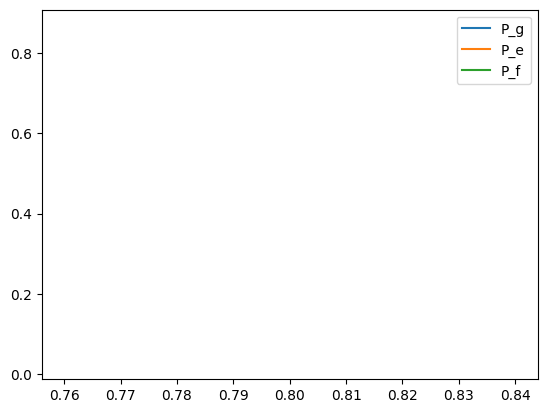

In [7]:
plt.plot(amp_list, P_g, label="P_g")
plt.plot(amp_list, P_e, label="P_e")
plt.plot(amp_list, P_f, label="P_f")
plt.legend()